# 在这一章我们主要讲 Pontragin's Minimum Principle 和 LQR 问题

# 1. Pontragin's Minimum Principle
简单来说，PMP给出了如下内容：

- **Hamiltonian 构造**：构建 Hamiltonian $ H(x, u, \lambda) $
- **状态方程**：描述系统动态（如 $ \dot{x} = f(x, u) $ 或离散型 $ x_{k+1} = f(x_k, u_k) $）。
- **协态方程**：即拉格朗日乘子（协态变量）$ \lambda $ 的动态方程（通常是反向积分的）。
- **最优性条件**：在每一时刻，控制量 $ u $ 要使 Hamiltonian 极小（或极大），即 $ u^* = \arg\min_u H(x, u, \lambda) $。
- **边界条件**：包括初始状态和终端状态/终端协态的条件。

问题描述：

考虑一个一维质点，其位置为 $x(t)$，速度为 $\dot{x}(t)$，可以通过控制加速度 $u(t)$ 来移动。目标是在给定时间 $T$ 内，将质点从初始状态 $x(0)=x_0, \dot{x}(0)=x_{0,1}$ 移动到目标状态 $x(T)=x_f, \dot{x}(T)=x_{f,1}$，并使控制消耗最小。

形式化描述如下：

- **状态变量**：$x(t)$（位置），$\dot{x}(t)$（速度）
- **控制变量**：$u(t)$（加速度）
- **系统动力学**：
  $$
  \begin{cases}
  \dot{x}(t) = \dot{x}(t) \\
  \ddot{x}(t) = u(t)
  \end{cases}
  $$
- **性能指标（代价函数）**：
  $$
  J = \frac{1}{2} \int_0^T u^2(t) \, dt
  $$
- **边界条件**：
  $$
  x(0) = x_0, \quad \dot{x}(0) = x_{0,1} \\
  x(T) = x_f, \quad \dot{x}(T) = x_{f,1}
  $$

---

Pontryagin's Minimum Principle (PMP) 转换：

1. **Hamiltonian 构造**：
   $$
   H = \frac{1}{2}u^2 + \lambda_1 \dot{x} + \lambda_2 u
   $$
   其中 $\lambda_1, \lambda_2$ 为协态变量。

2. **状态方程**：
   $$
   \dot{x} = \dot{x} \\
   \dot{\dot{x}} = u
   $$

3. **协态方程**：
   $$
   \dot{\lambda}_1 = -\frac{\partial H}{\partial x} = 0 \\
   \dot{\lambda}_2 = -\frac{\partial H}{\partial \dot{x}} = -\lambda_1
   $$

4. **最优性条件**：
   $$
   \frac{\partial H}{\partial u} = u + \lambda_2 = 0 \implies u^* = -\lambda_2
   $$

5. **边界条件**：
   $$
   x(0) = x_0, \quad \dot{x}(0) = x_{0,1} \\
   x(T) = x_f, \quad \dot{x}(T) = x_{f,1}
   $$

这样，原最优控制问题被PMP转化为一组关于 $x, \dot{x}, \lambda_1, \lambda_2$ 的常微分方程和边界条件。

In [4]:
# JAX 实现的 PMP 系统和二次积分器的牛顿射线法
from __future__ import annotations

import jax
import jax.numpy as jnp
from jax import jacfwd, jit, lax
from functools import partial

# 为了在刚性/长时间区间上稳定射线法，建议使用更高精度
jax.config.update("jax_enable_x64", True)

# PMP 问题的微分方程，适用于带有 0.5*u^2 跑动代价的二次积分器
# 状态: y = [x, x_dot, lam1, lam2]，控制量 u = -lam2
# 动力学:
#   x_dot     = x_dot
#   x_dotdot = u = -lam2
#   lam1dot  = 0
#   lam2dot  = -lam1

def pmp_dynamics(y: jnp.ndarray) -> jnp.ndarray:
    x, x_dot, lam1, lam2 = y
    u = -lam2
    return jnp.array([x_dot, u, 0.0, -lam1])


def rk4_step(f, y, dt):
    k1 = f(y)
    k2 = f(y + 0.5 * dt * k1)
    k3 = f(y + 0.5 * dt * k2)
    k4 = f(y + dt * k3)
    return y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


@partial(jit, static_argnames=("N",))
def integrate_rk4(y0: jnp.ndarray, T: float, N: int):
    """
    固定步长的 RK4 积分器，适用于自治 PMP 微分方程。
    返回 (ts, ys)，ts 形状为 (N+1,)，ys 形状为 (N+1, 4)。
    """
    dt = T / N

    def step_fn(y, _):
        y_next = rk4_step(pmp_dynamics, y, dt)
        return y_next, y_next

    # 运行 N 步，收集除初始值外的所有状态；最后在前面加回初始值
    yN, y_traj_tail = lax.scan(step_fn, y0, xs=None, length=N)
    ys = jnp.vstack([y0[None, :], y_traj_tail])
    ts = jnp.linspace(0.0, T, N + 1)
    return ts, ys


@partial(jit, static_argnames=("N",))
def terminal_residual(theta: jnp.ndarray,
                      x0: float, x_dot0: float,
                      xf: float, x_dotf: float,
                      T: float, N: int) -> jnp.ndarray:
    """
    针对固定终端状态约束 x(T)=xf, x_dot(T)=x_dotf 的射线法残差。
    theta = [lam1(0), lam2(0)] 是未知的初始协态。
    """
    y0 = jnp.array([x0, x_dot0, theta[0], theta[1]])
    ts, ys = integrate_rk4(y0, T, N)
    xT, x_dotT = ys[-1, 0], ys[-1, 1]
    r = jnp.array([xT - xf, x_dotT - x_dotf])
    return r


def newton_shooting(x0: float, x_dot0: float,
                    xf: float, x_dotf: float,
                    T: float, N: int = 200,
                    theta0: tuple[float, float] = (0.0, 0.0),
                    tol: float = 1e-10, max_iter: int = 20):
    """
    针对 PMP 边值问题的牛顿射线法。

    返回: theta（初始协态），info 字典，以及积分得到的轨迹 (ts, ys)。
    """
    theta = jnp.array(theta0, dtype=jnp.float64)

    # 计算残差对 theta 的 JAX 雅可比矩阵
    jac_fn = jacfwd(lambda th: terminal_residual(th, x0, x_dot0, xf, x_dotf, T, N))

    it = 0
    hist = []
    for it in range(max_iter):
        r = terminal_residual(theta, x0, x_dot0, xf, x_dotf, T, N)
        J = jac_fn(theta)
        # 求解 J * delta = -r
        delta = jnp.linalg.solve(J, -r)
        theta = theta + delta
        norm_r = float(jnp.linalg.norm(r))
        hist.append(norm_r)
        if norm_r < tol:
            break

    # 用最终的 theta 积分输出轨迹
    y0 = jnp.array([x0, x_dot0, theta[0], theta[1]])
    ts, ys = integrate_rk4(y0, T, N)

    info = {
        "iterations": it + 1,
        "residual_norm": hist[-1] if hist else None,
        "history": hist,
        "theta": theta,
    }
    return theta, info, (ts, ys)


# 从轨迹中提取控制量的小工具
@jit
def control_from_traj(ys: jnp.ndarray) -> jnp.ndarray:
    # u(t) = -lam2(t)
    return -ys[:, 3]


迭代次数: 2
残差范数: 9.402966096070957e-15
theta* (lam1(0), lam2(0)): [-12.  -6.]
x(T), x_dot(T) = 1.0000000000000009 2.819667474044755e-15


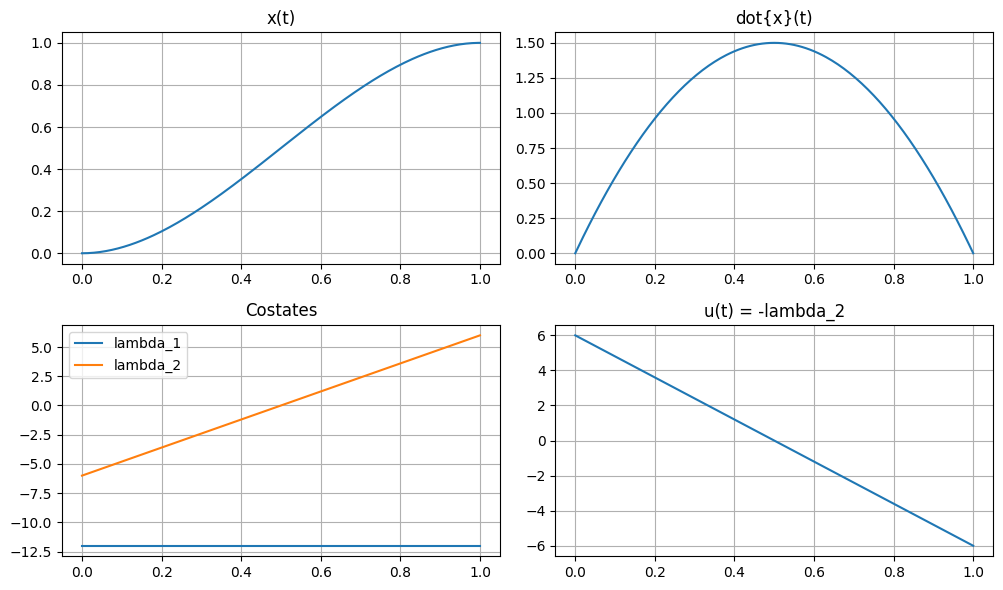

In [5]:
# 示例：用PMP+牛顿射线法求解二次积分器边值问题，并画出轨迹
import numpy as np
import matplotlib.pyplot as plt

# 问题设置
x0, x_dot0 = 0.0, 0.0
xf, x_dotf = 1.0, 0.0
T = 1.0
N = 200

# 初始协态猜测（可为零）
theta0 = (0.0, 0.0)

theta, info, (ts, ys) = newton_shooting(x0, x_dot0, xf, x_dotf, T, N=N, theta0=theta0)
print("迭代次数:", info["iterations"])
print("残差范数:", info["residual_norm"])
print("theta* (lam1(0), lam2(0)):", np.array(info["theta"]))

# 提取信号
x = np.array(ys[:, 0])
x_dot = np.array(ys[:, 1])
lam1 = np.array(ys[:, 2])
lam2 = np.array(ys[:, 3])
u = np.array(control_from_traj(ys))

# 检查终端条件
print("x(T), x_dot(T) =", x[-1], x_dot[-1])

# 绘图
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0, 0].plot(ts, x); axs[0, 0].set_title("x(t)")
axs[0, 1].plot(ts, x_dot); axs[0, 1].set_title("dot{x}(t)")
axs[1, 0].plot(ts, lam1, label="lambda_1"); axs[1, 0].plot(ts, lam2, label="lambda_2")
axs[1, 0].set_title("Costates"); axs[1, 0].legend()
axs[1, 1].plot(ts, u); axs[1, 1].set_title("u(t) = -lambda_2")
for ax in axs.ravel():
    ax.grid(True)
plt.tight_layout(); plt.show()


## Shooting方法简介

Shooting方法（射线法，打靶法）是一种求解PMP两点边值问题的数值方法。其基本思想和步骤如下：

- **PMP变换**：Pontryagin最小值原理（PMP）将最优控制问题转化为一组常微分方程（ODE），包括状态方程和协态方程，以及最优性条件和边界条件。
- **两点边值问题**：这组ODE通常表现为“初始状态已知，终端协态未知”（或反之），属于典型的两点边值问题（Boundary Value Problem, BVP）。
- **Shooting法思想**：Shooting法通过猜测未知的边界值（如初始协态$\lambda$），正向积分状态方程，反向积分协态方程，然后根据终端条件调整猜测，直到边界条件被满足。
- **形象理解**：就像“打靶”一样，不断调整初始“炮口方向”，使得“炮弹”最终正好命中目标（即满足终端条件）。

Shooting方法是连接最优控制理论与数值求解的重要桥梁，适用于多种最优控制问题的实际计算。

## 普通版本（NumPy）+ 自写优化器

这里给出不依赖 JAX 的普通实现，使用 NumPy 完成：
- 二次积分器的 PMP 动力学与 RK4 积分；
- 打靶（Shooting）残差构造；
- 自写优化器：Newton 与 Gauss-Newton（支持简单阻尼与回溯线搜索）。

说明：
- Newton 法直接解 J Δ = −r（求残差零点）。
- Gauss-Newton 法最小化 1/2‖r(θ)‖²，解 (JᵀJ + λI)Δ = −Jᵀr（λ≥0 为阻尼，可设 0）。
- 可选回溯线搜索以增强收敛稳健性。

这是根据Pontryagin最小值原理（PMP）推导出来的，具体如下：

1. Hamiltonian 构造
原问题的Hamiltonian为： $$ H = \frac{1}{2}u^2 + \lambda_1 \dot{x} + \lambda_2 u $$

2. 状态变量与协态变量
状态变量：$x, \dot{x}$
协态变量：$\lambda_1, \lambda_2$
组成状态向量 $y = [x, \dot{x}, \lambda_1, \lambda_2]$
3. 状态方程
$$ \dot{x} = \dot{x} \ \dot{\dot{x}} = u $$

4. 协态方程
$$ \dot{\lambda}_1 = -\frac{\partial H}{\partial x} = 0 \ \dot{\lambda}_2 = -\frac{\partial H}{\partial \dot{x}} = -\lambda_1 $$

5. 最优性条件
$$ \frac{\partial H}{\partial u} = u + \lambda_2 = 0 \implies u^* = -\lambda_2 $$

6. 合成微分方程
将上述所有微分方程写成一组一阶常微分方程：

$\dot{x} = x_{dot}$
$\dot{x}_{dot} = u = -\lambda_2$
$\dot{\lambda}_1 = 0$
$\dot{\lambda}_2 = -\lambda_1$

In [6]:
# NumPy 版本的 PMP + Shooting + 自写优化器（Newton / Gauss-Newton）
import numpy as np

# --------- PMP 动力学 for 二次积分器 ---------
# 状态 y = [x, x_dot, lam1, lam2], 控制 u = -lam2
# dy/dt = [x_dot, u, 0, -lam1]

def hamiltonian(x, x_dot, lam1, lam2, u):
    return 0.5 * u**2 + lam1 * x_dot + lam2 * u

# 最优性条件：u_k = argmin_u H(x_k, u, lambda_k)
def argmin_u_H(x, x_dot, lam1, lam2):
    # 对于本问题，H对u的导数为u + lam2 = 0
    # 更一般的情况可以用scipy.optimize.minimize_scalar
    return -lam2

from scipy.optimize import minimize_scalar
def argmin_u_H_standard(x, x_dot, lam1, lam2):
    # 标准 PMP 方法， u= argmin_u H(x, x_dot, lam1, lam2)
    # 这里 H = 0.5 * u^2 + lam1 * x_dot + lam2 * u
    # 对 u 求导并令其为零，得到 u = -lam2
    # 但为了更一般的情况，我们使用最小化器
    res = minimize_scalar(lambda u: hamiltonian(x, x_dot, lam1, lam2, u))
    return res.x

def pmp_dynamics_np(y: np.ndarray) -> np.ndarray:
    x, x_dot, lam1, lam2 = y
    # u = argmin_u_H(x, x_dot, lam1, lam2)
    u = argmin_u_H_standard(x, x_dot, lam1, lam2)  # 使用标准方法
    return np.array([x_dot, u, 0.0, -lam1], dtype=float)


# --------- RK4 固定步长积分器 ---------

def rk4_step_np(f, y: np.ndarray, dt: float) -> np.ndarray:
    k1 = f(y)
    k2 = f(y + 0.5 * dt * k1)
    k3 = f(y + 0.5 * dt * k2)
    k4 = f(y + dt * k3)
    return y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# 用 RK4 将PMP动力学方程从 t=0 积分到 t=T，并返回每个时刻的状态轨迹。
def integrate_rk4_np(y0: np.ndarray, T: float, N: int):
    dt = T / float(N)
    ys = np.zeros((N + 1, y0.size), dtype=float)
    ys[0] = y0
    for k in range(N):
        ys[k + 1] = rk4_step_np(pmp_dynamics_np, ys[k], dt)
    ts = np.linspace(0.0, T, N + 1)
    return ts, ys


# --------- Shooting 残差 ---------
# 衡量当前协态初值猜测 theta 是否能让系统轨迹满足终端状态约束。
def terminal_residual_np(theta: np.ndarray,
                         x0: float, x_dot0: float,
                         xf: float, x_dotf: float,
                         T: float, N: int) -> np.ndarray:
    """     针对固定终端状态约束 
                x(T)=xf, x_dot(T)=x_dotf 
                的射线法残差。
            theta = [lam1(0), lam2(0)] 是未知的初始协态。
    """
    # 初始状态 y0 = [x0, x_dot0, lam1(0), lam2(0)]
    y0 = np.array([x0, x_dot0, theta[0], theta[1]], dtype=float)
    ts, ys = integrate_rk4_np(y0, T, N)
    xT, x_dotT = ys[-1, 0], ys[-1, 1]
    return np.array([xT - xf, x_dotT - x_dotf], dtype=float)


# --------- 数值雅可比（前向差分）---------
def finite_diff_jacobian(fun, theta: np.ndarray, eps: float = 1e-7, *args) -> np.ndarray:
    """
    计算函数 fun 在 theta 处的数值雅可比矩阵。
    fun 应接受参数 theta 和其他可选参数 args。
    返回形状为 (m, n) 的雅可比矩阵，其中 m 是 fun 的输出维度，n 是 theta 的维度。
    """
    eps = float(eps)
    r0 = fun(theta, *args)
    m = r0.size
    n = theta.size
    J = np.zeros((m, n), dtype=float)
    for j in range(n):
        e = np.zeros_like(theta)
        e[j] = max(eps, eps * abs(theta[j]))
        r1 = fun(theta + e, *args)
        J[:, j] = (r1 - r0) / e[j]
    return J


# --------- 线搜索（回溯，Armijo 条件）---------

def backtracking_line_search(fun, theta: np.ndarray, d: np.ndarray, r: np.ndarray,
                             J: np.ndarray | None = None,  # 若提供 J，可用于 GN 的 φ
                             alpha0: float = 1.0, c: float = 1e-4, rho: float = 0.5,
                             max_backtrack: int = 20, mode: str = "newton"):
    """
    回溯线搜索，满足 Armijo 条件。
        fun: 目标函数，接受参数 theta 和其他 args。
        theta: 当前点。
        d: 搜索方向（通常是梯度或牛顿方向）。
        r: 当前残差（用于计算 φ 的初始值）。
        J: 雅可比矩阵（可选，用于 Gauss-Newton 方法）。
        alpha0: 初始步长。
        c: Armijo 条件的常数。
        rho: 步长缩减因子。
        max_backtrack: 最大回溯次数。

    返回 (alpha, new_theta, new_r)，其中 new_theta 是新的参数，new_r 是新的残差。
    """
    # 目标：
    # - newton: ϕ(θ) = 0.5 * ||r(θ)||^2，使用 r·(J d) 近似方向导数
    # - gauss-newton: 同上
    phi0 = 0.5 * float(np.dot(r, r))
    alpha = alpha0
    for _ in range(max_backtrack):
        th_new = theta + alpha * d
        r_new = fun(th_new)
        phi_new = 0.5 * float(np.dot(r_new, r_new))
        if J is None:
            # 若无 J，采用简单充分下降判据（数值上偏保守）
            if phi_new <= (1 - c * alpha) * phi0:
                return alpha, th_new, r_new
        else:
            Jd = J @ d
            directional = float(np.dot(r, Jd))  # dϕ ≈ rᵀ J d
            if phi_new <= phi0 + c * alpha * directional:
                return alpha, th_new, r_new
        alpha *= rho
    return alpha, theta + alpha * d, fun(theta + alpha * d)


# --------- 自写优化器：Newton / Gauss-Newton ---------

def solve_by_newton(Residual, theta0: np.ndarray, args: tuple,
                    tol: float = 1e-10, max_iter: int = 25,
                    use_linesearch: bool = True):
    theta = np.array(theta0, dtype=float)
    hist = []
    for it in range(max_iter):
        r = Residual(theta, *args)
        nr = float(np.linalg.norm(r))
        hist.append(nr)
        if nr < tol:
            break
        J = finite_diff_jacobian(Residual, theta, 1e-7, *args)
        # Newton 步：J Δ = −r
        try:
            delta = np.linalg.solve(J, -r)
        except np.linalg.LinAlgError:
            # 退化时最小二乘解
            delta = np.linalg.lstsq(J, -r, rcond=None)[0]
        if use_linesearch:
            fun = lambda th: Residual(th, *args)
            _, theta, r = backtracking_line_search(fun, theta, delta, r, J=J, mode="newton")
        else:
            theta = theta + delta
    info = {"iterations": len(hist), "history": hist, "residual_norm": hist[-1] if hist else None}
    return theta, info


def solve_by_gauss_newton(Residual, theta0: np.ndarray, args: tuple,
                          tol: float = 1e-10, max_iter: int = 25,
                          damping: float = 0.0, use_linesearch: bool = True):
    theta = np.array(theta0, dtype=float)
    hist = []
    for it in range(max_iter):
        r = Residual(theta, *args)
        nr = float(np.linalg.norm(r))
        hist.append(nr)
        if nr < tol:
            break
        J = finite_diff_jacobian(Residual, theta, 1e-7, *args)
        A = J.T @ J + damping * np.eye(theta.size)
        b = -J.T @ r
        try:
            delta = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            delta = np.linalg.lstsq(A, b, rcond=None)[0]
        if use_linesearch:
            fun = lambda th: Residual(th, *args)
            _, theta, r = backtracking_line_search(fun, theta, delta, r, J=J, mode="gauss-newton")
        else:
            theta = theta + delta
    info = {"iterations": len(hist), "history": hist, "residual_norm": hist[-1] if hist else None}
    return theta, info


# --------- 高层接口：用 Shooting + 选择优化器 ---------

def shooting_solve_np(x0: float, x_dot0: float, xf: float, x_dotf: float,
                      T: float, N: int = 200, theta0=(0.0, 0.0),
                      method: str = "newton", damping: float = 0.0,
                      tol: float = 1e-10, max_iter: int = 25, use_linesearch: bool = True):
    args = (x0, x_dot0, xf, x_dotf, T, N)
    Residual = lambda th, *a: terminal_residual_np(th, *a)
    theta0 = np.array(theta0, dtype=float)
    if method.lower() in ["newton", "n"]:
        theta, info = solve_by_newton(Residual, theta0, args, tol=tol, max_iter=max_iter, use_linesearch=use_linesearch)
    elif method.lower() in ["gauss-newton", "gn", "gaussnewton"]:
        theta, info = solve_by_gauss_newton(Residual, theta0, args, tol=tol, max_iter=max_iter,
                                            damping=damping, use_linesearch=use_linesearch)
    else:
        raise ValueError("method must be 'newton' or 'gauss-newton'")
    # 返回轨迹
    y0 = np.array([x0, x_dot0, theta[0], theta[1]], dtype=float)
    ts, ys = integrate_rk4_np(y0, T, N)
    return theta, info, (ts, ys)


# 小工具：从轨迹提取控制

def control_from_traj_np(ys: np.ndarray) -> np.ndarray:
    return -ys[:, 3]


history: [1.0, 1.1592124639264833e-08, 3.793872837597678e-09, 3.634917869784911e-09, 7.645561870328791e-10, 4.3656818123227896e-10, 2.7529495368256742e-09, 1.3676619828610599e-09, 7.436613173815888e-10, 3.8658293022686927e-10, 2.7520074581550573e-10, 3.227408401751464e-09, 1.7712884318238522e-09, 8.31451757062519e-10, 5.496917619507701e-10, 2.0575735707643442e-10, 1.8201412140406322e-09, 7.023687437088842e-10, 4.840675441969334e-10, 3.7470817342814066e-10, 3.698352300680221e-10, 4.1258892767590276e-09, 1.3084641199765906e-09, 1.2043764297915275e-09, 4.115069466042981e-10]
迭代次数: 25
残差范数: 4.115069466042981e-10
theta* (lam1(0), lam2(0)): [-12.00000001  -6.        ]
x(T), x_dot(T) = 0.9999999995236142 -9.308159590326603e-10


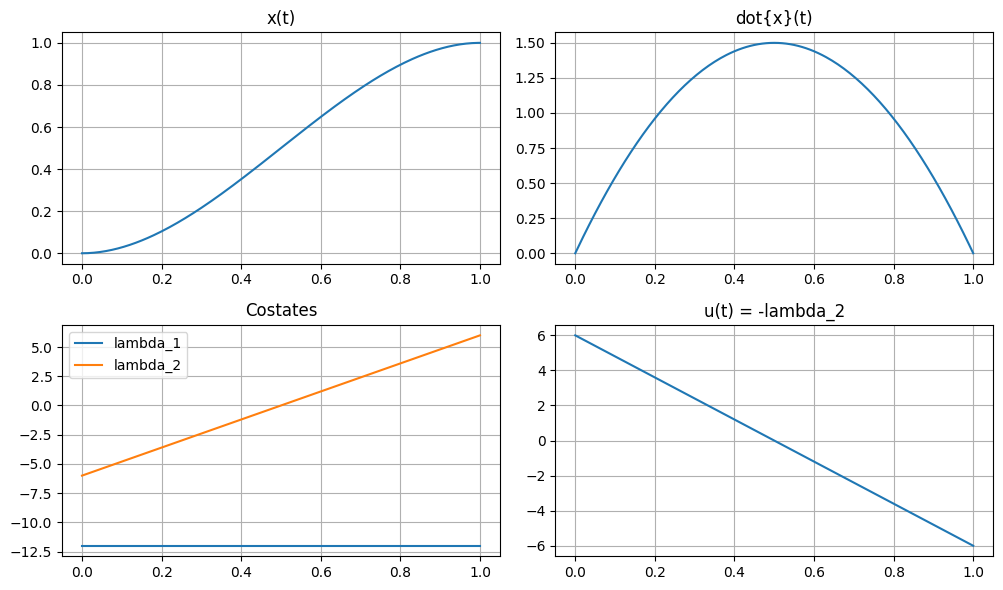

In [7]:
# 例子：使用 NumPy + 自写优化器求解
import numpy as np
import matplotlib.pyplot as plt

x0, x_dot0 = 0.0, 0.0
xf, x_dotf = 1.0, 0.0
T = 1.0
N = 200

# 选择优化方法："newton" 或 "gauss-newton"
method = "newton"  # 改为 "gauss-newton" 试试

theta0 = (0.0, 0.0)
if method == "gauss-newton":
    theta, info, (ts, ys) = shooting_solve_np(x0, x_dot0, xf, x_dotf, T, N,
                                              theta0=theta0, method=method,
                                              damping=1e-8, tol=1e-10, max_iter=25,
                                              use_linesearch=True)
else:
    theta, info, (ts, ys) = shooting_solve_np(x0, x_dot0, xf, x_dotf, T, N,
                                              theta0=theta0, method=method,
                                              tol=1e-10, max_iter=25, use_linesearch=True)

print("history:", info["history"])
print("迭代次数:", info["iterations"])
print("残差范数:", info["residual_norm"])
print("theta* (lam1(0), lam2(0)):", np.array(theta))

x = ys[:, 0]
x_dot = ys[:, 1]
lam1 = ys[:, 2]
lam2 = ys[:, 3]
u = control_from_traj_np(ys)

print("x(T), x_dot(T) =", x[-1], x_dot[-1])

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0, 0].plot(ts, x); axs[0, 0].set_title("x(t)")
axs[0, 1].plot(ts, x_dot); axs[0, 1].set_title("dot{x}(t)")
axs[1, 0].plot(ts, lam1, label="lambda_1"); axs[1, 0].plot(ts, lam2, label="lambda_2")
axs[1, 0].set_title("Costates"); axs[1, 0].legend()
axs[1, 1].plot(ts, u); axs[1, 1].set_title("u(t) = -lambda_2")
for ax in axs.ravel():
    ax.grid(True)
plt.tight_layout(); plt.show()

# 2. LQR

本节考虑离散时间 LQR 问题：在线性离散动力学与给定初值下，最小化二次型代价。

- 动力学： 
$x_{k+1} = A x_k + B u_k,  x_0 = x_0$
- 代价： 
$J = 1/2·x_N^T Q_n x_N + Σ_{k=0}^{N-2} 1/2·(x_k^T Q x_k + u_k^T R u_k)$


这里我们采用双积分器(double integrator)的离散化作为示例：
- A = [[1, h], [0, 1]]
- B = [[0.5·h^2], [h]]

两种求解思路：
1) Riccati 递推（标准 LQR）
   - $P_N = Q_n$
   - $K_k = (R + B^T P_{k+1} B)^{-1} B^T P_{k+1} A$
   - $P_k = Q + A^T P_{k+1} (A - B K_k)$
   - $u_k = -K_k x_k$（时变反馈）

2) Shooting（与 Julia 代码一致的“打靶/梯度下降”法）
   - 协态反向递推：$λ_N = Q_n x_N，λ_k = Q x_k + A^T λ_{k+1}$
   - 梯度方向：$Δu_k = -(u_k + R^{-1} B^T λ_{k+1})$
   - 线搜索：α 从 1 开始回溯，直至满足充分下降条件，再执行前向 rollout 更新 (x, u)。

下方首先给出 Riccati 解法的实现，然后给出与 Julia 相同逻辑的 shooting 解法并与之对比。

## 2.1 LQR + shooting 方法

[LQR-Riccati] cost: 6.658612208961309


C:\Users\lvxiangyu11\AppData\Local\Temp\ipykernel_24304\2071766325.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = -float(K[k] @ xs[:, k])


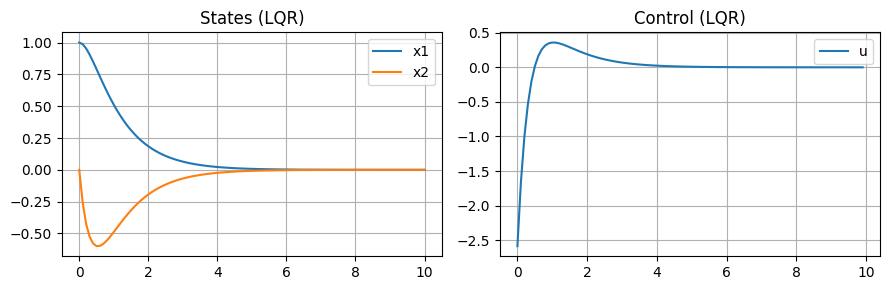

In [8]:
# 离散 LQR：Riccati 递推 + rollout
import numpy as np
import matplotlib.pyplot as plt

# 与 Julia 一致的设置
h = 0.1
A = np.array([[1.0, h],[0.0, 1.0]], dtype=float)
B = np.array([[0.5*h*h],[h]], dtype=float)
n, m = 2, 1
Tfinal = 10.0
N = int(Tfinal/h) + 1
thist = np.linspace(0.0, h*(N-1), N)

x0 = np.array([1.0, 0.0], dtype=float)
Q = np.eye(2)
R = np.array([[0.1]], dtype=float)
Qn = np.eye(2)

def lqr_backward_riccati(A, B, Q, R, Qn, N):
    P = [None]*N
    K = [None]*(N-1)
    P[-1] = Qn.copy()
    for k in range(N-2, -1, -1):
        BtP = B.T @ P[k+1]
        G = R + BtP @ B
        K[k] = np.linalg.solve(G, BtP @ A)
        AK = A - B @ K[k]
        P[k] = Q + A.T @ P[k+1] @ AK
    return P, K

def rollout_feedback(A, B, K, x0):
    xs = np.zeros((n, N), dtype=float)
    us = np.zeros(N-1, dtype=float)
    xs[:, 0] = x0
    for k in range(N-1):
        u = -float(K[k] @ xs[:, k])
        us[k] = u
        xs[:, k+1] = A @ xs[:, k] + (B[:, 0] * u)
    return xs, us

def cost_J(xs, us, Q, R, Qn):
    cost = 0.5 * xs[:, -1].T @ Qn @ xs[:, -1]
    for k in range(N-1):
        cost += 0.5 * xs[:, k].T @ Q @ xs[:, k] + 0.5 * float(us[k] * (R[0,0] * us[k]))
    return float(cost)

P, K = lqr_backward_riccati(A, B, Q, R, Qn, N)
x_lqr, u_lqr = rollout_feedback(A, B, K, x0)
J_lqr = cost_J(x_lqr, u_lqr, Q, R, Qn)
print("[LQR-Riccati] cost:", J_lqr)

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].plot(thist, x_lqr[0], label='x1')
axs[0].plot(thist, x_lqr[1], label='x2')
axs[0].set_title('States (LQR)'); axs[0].legend(); axs[0].grid(True)
axs[1].plot(thist[:-1], u_lqr, label='u')
axs[1].set_title('Control (LQR)'); axs[1].legend(); axs[1].grid(True)
plt.tight_layout(); plt.show()

In [9]:
# LQR 的 shooting（打靶/梯度下降）实现，匹配 Julia 逻辑
import numpy as np

def J_shoot(xs, us, Q, R, Qn):
    cost = 0.5 * xs[:, -1].T @ Qn @ xs[:, -1]
    for k in range(N-1):
        cost += 0.5 * xs[:, k].T @ Q @ xs[:, k] + 0.5 * float(us[k] * (R[0,0] * us[k]))
    return float(cost)

def rollout_openloop(A, B, x0, us):
    xs = np.zeros((n, N), dtype=float)
    xs[:, 0] = x0
    for k in range(N-1):
        xs[:, k+1] = A @ xs[:, k] + (B[:, 0] * float(us[k]))
    return xs

# 初始化
xhist = np.tile(x0.reshape(-1,1), (1, N))
uhist = np.zeros(N-1, dtype=float)
Δu = np.ones(N-1, dtype=float)
lam = np.zeros((n, N), dtype=float)

# 初始 rollout
xhist = rollout_openloop(A, B, x0, uhist)
print("[Shooting] initial cost:", J_shoot(xhist, uhist, Q, R, Qn))

b = 1e-2
iter_ = 0
while np.max(np.abs(Δu)) > 1e-2 and iter_ < 10_000:
    # 反向递推协态 + 计算搜索方向 Δu
    lam[:, -1] = Qn @ xhist[:, -1]
    for k in range(N-2, -1, -1):
        Δu[k] = -(uhist[k] + float((np.linalg.solve(R, (B.T @ lam[:, k+1]).reshape(1,-1)))[0,0]))
        lam[:, k] = Q @ xhist[:, k] + A.T @ lam[:, k+1]
    # 线搜索并前向 rollout
    alpha = 1.0
    unew = uhist + alpha * Δu
    xnew = rollout_openloop(A, B, x0, unew)
    # Armijo 条件
    while J_shoot(xnew, unew, Q, R, Qn) > J_shoot(xhist, uhist, Q, R, Qn) - b*alpha*np.dot(Δu, Δu):
        alpha *= 0.5
        unew = uhist + alpha * Δu
        xnew = rollout_openloop(A, B, x0, unew)
        if alpha < 1e-12:
            break
    uhist = unew
    xhist = xnew
    iter_ += 1

J_sh = J_shoot(xhist, uhist, Q, R, Qn)
print("[Shooting] iter:", iter_)
print("[Shooting] cost:", J_sh)

[Shooting] initial cost: 50.5
[Shooting] iter: 2416
[Shooting] cost: 6.6586212414146955


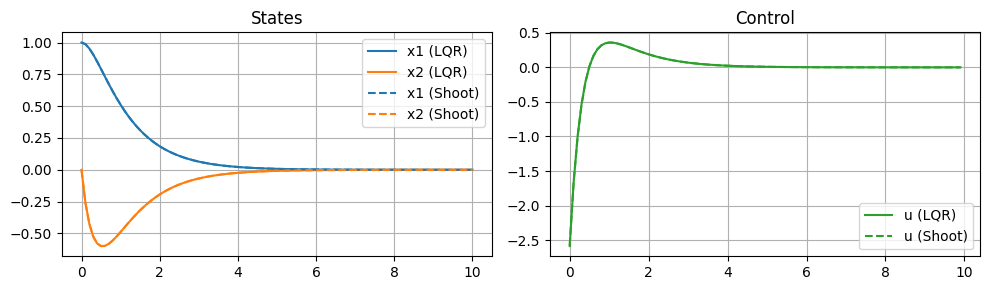

In [10]:
# 对比 Riccati 和 Shooting 的状态与控制
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(thist, x_lqr[0], 'C0', label='x1 (LQR)')
axs[0].plot(thist, x_lqr[1], 'C1', label='x2 (LQR)')
axs[0].plot(thist, xhist[0], 'C0--', label='x1 (Shoot)')
axs[0].plot(thist, xhist[1], 'C1--', label='x2 (Shoot)')
axs[0].set_title('States'); axs[0].legend(); axs[0].grid(True)

axs[1].plot(thist[:-1], u_lqr, 'C2', label='u (LQR)')
axs[1].plot(thist[:-1], uhist, 'C2--', label='u (Shoot)')
axs[1].set_title('Control'); axs[1].legend(); axs[1].grid(True)

plt.tight_layout(); plt.show()

## 2.2 LQR 的 QP/KKT 标准解法

这里给出将有限时域离散 LQR 写成二次规划（QP）的标准做法，并通过 KKT 线性系统一次性求解：

- 变量堆叠：z = [x1, x2, ..., xN, u0, u1, ..., u_{N-2}]
- 代价：0.5 z^T H z，其中 H 在状态部分为 blkdiag(Q,...,Q,Qn)，在控制部分为 blkdiag(R,...,R)
- 约束：C z = d，逐步编码动力学 x_{k+1} - A x_k - B u_k = 0（x0 已知，进入右端项 d）
- KKT 系统：
  [ H  C^T ] [ z ] = [ 0 ]
  [ C   0  ] [ λ ]   [ d ]

解得 z 后，可还原全轨迹与控制序列。

In [11]:
# 构建并求解 LQR 的 QP/KKT 形式
import numpy as np

# 复用已定义的 A, B, Q, R, Qn, N, n, m, x0, thist

nx, nu = n, 1  # 本例 nu=1
Nx = N  # x0..x_{N-1}, xN 共 N 个时刻，变量里只包含 x1..xN（x0 已知）
Nu = N-1

# 变量次序: z = [x1, x2, ..., xN, u0, u1, ..., u_{N-2}]
size_xblk = nx * (Nx)  # 从 x1 到 xN 的块数是 N（末端也含）
size_ublk = nu * (Nu)
Zdim = size_xblk + size_ublk

# H (正定块对角)
H = np.zeros((Zdim, Zdim), dtype=float)
# 状态权重：从 k=1..N-1 用 Q，末端 k=N 用 Qn
for k in range(1, N):
    H[(k-1)*nx:k*nx, (k-1)*nx:k*nx] = Q  # 对应 xk，k=1..N-1
H[(N-1)*nx:N*nx, (N-1)*nx:N*nx] = Qn      # 对应 xN
# 控制权重：u0..u_{N-2}
for k in range(Nu):
    i = size_xblk + k*nu
    H[i:i+nu, i:i+nu] = R

# 约束 C z = d，行数等于动力学约束数量：nx*(N-1)
C = np.zeros((nx*(N-1), Zdim), dtype=float)
d = np.zeros(nx*(N-1), dtype=float)

# 每个 k=0..N-2: 0 = x_{k+1} - A x_k - B u_k
# 其中 x_k: 若 k=0，用给定 x0，进入右端；若 k>=1，则在变量 z 中。
for k in range(N-1):
    row = k*nx
    # 列索引: x_{k+1} 在变量中位置：k+1 in [1..N-1] -> block k for x、末端 xN -> block N-1
    C[row:row+nx, (k)*nx:(k+1)*nx] += np.eye(nx)  # x_{k+1}
    # -A x_k
    if k == 0:
        d[row:row+nx] = A @ x0  # 移到右端（注意 KKT 右端是 d）
    else:
        C[row:row+nx, (k-1)*nx:k*nx] += -A
    # -B u_k
    u_col = size_xblk + k*nu
    C[row:row+nx, u_col:u_col+nu] += -B

# 组装 KKT
KKT = np.block([
    [H, C.T],
    [C, np.zeros((C.shape[0], C.shape[0]), dtype=float)]
])
rhs = np.concatenate([np.zeros(Zdim, dtype=float), d])

# 求解 KKT
sol = np.linalg.solve(KKT, rhs)
z = sol[:Zdim]
# lam = sol[Zdim:]  # 若需要拉格朗日乘子

# 解析出轨迹和控制
x_qp = np.zeros((nx, N), dtype=float)
u_qp = np.zeros(N-1, dtype=float)
x_qp[:, 0] = x0
for k in range(1, N):
    x_qp[:, k] = z[(k-1)*nx:k*nx]
for k in range(N-1):
    u_qp[k] = z[size_xblk + k*nu]

J_qp = (0.5 * x_qp[:, -1].T @ Qn @ x_qp[:, -1]
         + sum(0.5 * (x_qp[:, k].T @ Q @ x_qp[:, k]) for k in range(N-1))
         + sum(0.5 * (u_qp[k] * (R[0,0] * u_qp[k])) for k in range(N-1)))

print("[QP/KKT] cost:", float(J_qp))

[QP/KKT] cost: 6.658612208961547


### 2.3 三种方法的效率对比（Riccati vs Shooting vs QP/KKT）

下面用相同的系统规模，对三种方法进行计时比较。注意：
- Riccati 的复杂度约 O(N·n^3)，常数因子小，极快；
- Shooting 这里是简单的梯度下降，需多轮迭代与线搜索，速度受迭代次数影响；
- QP/KKT 需一次求解稠密 KKT 线性系统，复杂度与规模相关，对大 N 可能慢于 Riccati。

In [12]:
# 计时对比
import time
import numpy as np

repeats = 5

# 1) Riccati
ric_times = []
for _ in range(repeats):
    t0 = time.time()
    P_, K_ = lqr_backward_riccati(A, B, Q, R, Qn, N)
    x_lqr_b, u_lqr_b = rollout_feedback(A, B, K_, x0)
    J_lqr_b = cost_J(x_lqr_b, u_lqr_b, Q, R, Qn)
    ric_times.append(time.time() - t0)

# 2) Shooting（从零控制初始化，最多迭代与之前相同）
shoot_times = []
for _ in range(repeats):
    t0 = time.time()
    xhist_b = rollout_openloop(A, B, x0, np.zeros(N-1))
    uhist_b = np.zeros(N-1)
    Δu_b = np.ones(N-1)
    lam_b = np.zeros((n, N))
    b_ls = 1e-2
    iters = 0
    while np.max(np.abs(Δu_b)) > 1e-2 and iters < 10_000:
        lam_b[:, -1] = Qn @ xhist_b[:, -1]
        for k in range(N-2, -1, -1):
            Δu_b[k] = -(uhist_b[k] + float((np.linalg.solve(R, (B.T @ lam_b[:, k+1]).reshape(1,-1)))[0,0]))
            lam_b[:, k] = Q @ xhist_b[:, k] + A.T @ lam_b[:, k+1]
        alpha = 1.0
        unew = uhist_b + alpha * Δu_b
        xnew = rollout_openloop(A, B, x0, unew)
        while J_shoot(xnew, unew, Q, R, Qn) > J_shoot(xhist_b, uhist_b, Q, R, Qn) - b_ls*alpha*np.dot(Δu_b, Δu_b):
            alpha *= 0.5
            unew = uhist_b + alpha * Δu_b
            xnew = rollout_openloop(A, B, x0, unew)
            if alpha < 1e-12:
                break
        uhist_b = unew
        xhist_b = xnew
        iters += 1
    J_shoot_b = J_shoot(xhist_b, uhist_b, Q, R, Qn)
    shoot_times.append(time.time() - t0)

# 3) QP/KKT（按上面构造一次性求解）
qp_times = []
for _ in range(repeats):
    t0 = time.time()
    # 重新构造并求解 KKT（避免重用缓存影响计时）
    H = np.zeros((Zdim, Zdim), dtype=float)
    for k in range(1, N):
        H[(k-1)*nx:k*nx, (k-1)*nx:k*nx] = Q
    H[(N-1)*nx:N*nx, (N-1)*nx:N*nx] = Qn
    for k in range(Nu):
        i = size_xblk + k*nu
        H[i:i+nu, i:i+nu] = R
    C = np.zeros((nx*(N-1), Zdim), dtype=float)
    d = np.zeros(nx*(N-1), dtype=float)
    for k in range(N-1):
        row = k*nx
        C[row:row+nx, (k)*nx:(k+1)*nx] += np.eye(nx)
        if k == 0:
            d[row:row+nx] = A @ x0
        else:
            C[row:row+nx, (k-1)*nx:k*nx] += -A
        u_col = size_xblk + k*nu
        C[row:row+nx, u_col:u_col+nu] += -B
    KKT = np.block([[H, C.T],[C, np.zeros((C.shape[0], C.shape[0]), dtype=float)]])
    rhs = np.concatenate([np.zeros(Zdim, dtype=float), d])
    sol = np.linalg.solve(KKT, rhs)
    z = sol[:Zdim]
    x_qp_b = np.zeros((nx, N), dtype=float)
    u_qp_b = np.zeros(N-1, dtype=float)
    x_qp_b[:, 0] = x0
    for k in range(1, N):
        x_qp_b[:, k] = z[(k-1)*nx:k*nx]
    for k in range(N-1):
        u_qp_b[k] = z[size_xblk + k*nu]
    J_qp_b = (0.5 * x_qp_b[:, -1].T @ Qn @ x_qp_b[:, -1]
              + sum(0.5 * (x_qp_b[:, k].T @ Q @ x_qp_b[:, k]) for k in range(N-1))
              + sum(0.5 * (u_qp_b[k] * (R[0,0] * u_qp_b[k])) for k in range(N-1)))
    qp_times.append(time.time() - t0)

print("Avg time (ms): Riccati=%.3f, Shooting=%.3f, QP/KKT=%.3f" %
      (1e3*np.mean(ric_times), 1e3*np.mean(shoot_times), 1e3*np.mean(qp_times)))

# 成本一致性（数值误差允许极小差别）
print("Costs:")
print("  Riccati:", float(J_lqr_b))
print("  Shooting:", float(J_shoot_b))
print("  QP/KKT:", float(J_qp))

C:\Users\lvxiangyu11\AppData\Local\Temp\ipykernel_24304\2071766325.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = -float(K[k] @ xs[:, k])


Avg time (ms): Riccati=1.573, Shooting=22219.770, QP/KKT=3.878
Costs:
  Riccati: 6.658612208961309
  Shooting: 6.6586212414146955
  QP/KKT: 6.658612208961547


# 3. 使用INH-LQR处理 ** 目标跟踪**问题


## 3.1 构建线性模型
1. **选择线性化点**  
   选定目标点 $$(\hat{q}, \dot{\hat{q}}=0)$$ 作为线性化点。

2. **动力学模型**  
   机械臂的离散动力学近似为：
   $$
   \begin{align*}
   q_{k+1} &= q_k + \dot{q}_k \cdot dt \\
   \dot{q}_{k+1} &= \dot{q}_k + M(\hat{q})^{-1} \left[ u_k - \hat{u} - J_g (q_k - \hat{q}) \right] dt
   \end{align*}
   $$
   其中 $M(\hat{q})$ 是质量矩阵，$J_g = \frac{\partial g}{\partial q}\big|_{\hat{q}}$ 是重力项对关节的雅可比，$\hat{u} = g(\hat{q})$。

2.1. 推导
   机械臂的关节空间动力学一般写作：
   $$
   \begin{align*}
   [ M(q)\ddot{q} + C(q, \dot{q})\dot{q} + g(q) = u ]
   \end{align*}
   $$
   线性化通常围绕某个平衡点 $$(\hat{q}, \hat{\dot{q}}, \hat{u})$$ 进行。对 $$(q, \dot{q}, u)$$ 做一阶泰勒展开，得到：

   $$
   M(\hat{q})\,\delta\ddot{q} + C(\hat{q}, \hat{\dot{q}})\,\delta\dot{q} + \frac{\partial g}{\partial q}\bigg|_{\hat{q}}\,\delta q = \delta u
   $$

   其中 $\delta q = q - \hat{q}, \delta \dot{q} = \dot{q} - \hat{\dot{q}},\delta u = u - \hat{u}$

   离散化后，忽略科氏项（或假设在平衡点附近很小），可得：

   $$
   \dot{q}_{k+1} = \dot{q}_k + M(\hat{q})^{-1} \left[ u_k - \hat{u} - J_g (q_k - \hat{q}) \right] dt
   $$

   其中 $$(J_g = \frac{\partial g}{\partial q}\big|_{\hat{q}})$$

3. **状态变量定义**  
   $$
   x = \begin{bmatrix} q \\ \dot{q} \end{bmatrix} \in \mathbb{R}^{2n}
   $$
   控制输入 $u \in \mathbb{R}^n$。

4. **线性化后的离散系统**  
   $$
   x_{k+1} = A x_k + B u_k
   $$
   其中
   $$
   A = \begin{bmatrix}
   I & dt \cdot I \\
   -dt \cdot M^{-1} J_g & I
   \end{bmatrix}
   $$
   $$
   B = \begin{bmatrix}
   0 \\
   dt \cdot M^{-1}
   \end{bmatrix}
   $$

5. **LQR 代价函数**  
   $$
   J = \sum_{k=0}^{\infty} (x_k - x^*)^T Q (x_k - x^*) + (u_k - u^*)^T R (u_k - u^*)
   $$
   其中
   $$
   Q = \begin{bmatrix}
   Q_{pos} \cdot I & 0 \\
   0 & Q_{vel} \cdot I
   \end{bmatrix}, \quad
   R = r \cdot I
   $$

6. **LQR反馈增益求解**  
   通过离散Riccati方程迭代，求解最优反馈增益
   $$
   K = (R + B^T P B)^{-1} (B^T P A)
   $$
   其中 $P$ 为Riccati方程的解。

7. **返回**  
   返回 $(A, B, K, P, g(\hat{q}))$ 供主控循环使用。


# 3.2 INH-LQR 模拟步
1. **读取当前状态**  
   读取当前关节角 $q$ 和速度 $\dot{q}$，拼成状态向量 $x = [q; \dot{q}]$。

2. **计算目标状态**  
   目标状态 $x_{\text{goal}} = [q_{\text{goal}}; 0]$。

3. **计算状态误差**  
   $$
   e = x - x_{\text{goal}}
   $$

4. **重力补偿**  
   计算当前重力力矩 $g(q)$（或者用目标点的 $g(q_{\text{goal}})$）。

5. **LQR控制律**  
   $$
   u = g(q) - K (x - x_{\text{goal}})
   $$
   其中 $K$ 是预先计算好的反馈增益。

6. **力矩限幅**  
   对 $u$ 做限幅，防止超出物理极限。

7. **施加控制**  
   用 `apply_torque` 将 $u$ 作用到仿真机器人。

8. **推进仿真**  
   调用 `p.stepSimulation()` 推进一步。